## <font color='darkblue'>Introduction</font>
([article source](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)) This script demonstrates how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.

## <font color='darkblue'>Setup</font>
Import the required packages:

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

### <font color='darkgreen'>Load the data</font>
We will use the [**Numenta Anomaly Benchmark(NAB) dataset**](https://www.kaggle.com/boltzmannbrain/nab). It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the `art_daily_jumpsup.csv` file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
df_small_noise = pd.read_csv(
    '../../datas/kaggle_numenta_anomaly_benchmark/art_daily_small_noise.csv',
    parse_dates=True,
    index_col="timestamp"
)

df_daily_jumpsup = pd.read_csv(
    '../../datas/kaggle_numenta_anomaly_benchmark/art_daily_jumpsup.csv',
    parse_dates=True,
    index_col="timestamp"
)

### <font color='darkgreen'>Quick look at the data</font>

In [3]:
df_small_noise.head(n=10)

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
2014-04-01 00:25:00,21.175272
2014-04-01 00:30:00,20.637692
2014-04-01 00:35:00,20.311228
2014-04-01 00:40:00,21.464406


In [4]:
df_daily_jumpsup.head(n=10)

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
2014-04-01 00:25:00,19.923126
2014-04-01 00:30:00,21.698404
2014-04-01 00:35:00,20.878758
2014-04-01 00:40:00,18.446200


## <font color='darkblue'>Visualize the data</font>

### <font color='darkgreen'>Timeseries data without anomalies</font>
We will use the following data for training.

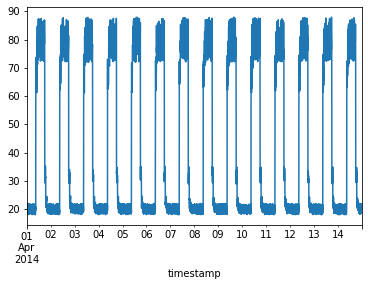

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### <font color='darkgreen'>Timeseries data with anomalies</font>
We will use the following data for testing and see if the sudden jump up in the data is detected as an anomaly.

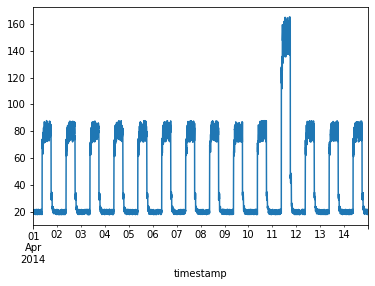

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## <font color='darkblue'>Prepare training data</font>
Get data values from the training timeseries data file and normalize the `value` data. We have a value for every 5 mins for 14 days.
* 24 * 60 / 5 = 288 timesteps per day
* 288 * 14 = 4032 data points in total

In [7]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
df_training_value.values.shape

(4032, 1)

### <font color='darkgreen'>Create sequences</font>
Create sequences combining `TIME_STEPS` contiguous data values from the training data.

In [9]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## <font color='darkblue'>Build a model</font>
We will build a **convolutional reconstruction autoencoder model**. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length` is 288 and `num_features` is 1.

In [11]:
def get_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

model = get_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

## <font color='darkblue'>Train the model</font>
Please note that we are using `x_train` as both the input and the target since this is a **reconstruction model**.

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 2s 56ms/step - loss: 0.7173 - val_loss: 0.0805
Epoch 2/50
27/27 [==============================] - 1s 30ms/step - loss: 0.0923 - val_loss: 0.0434
Epoch 3/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0617 - val_loss: 0.0399
Epoch 4/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0520 - val_loss: 0.0353
Epoch 5/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0458 - val_loss: 0.0311
Epoch 6/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0410 - val_loss: 0.0297
Epoch 7/50
27/27 [==============================] - 1s 30ms/step - loss: 0.0369 - val_loss: 0.0268
Epoch 8/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0334 - val_loss: 0.0262
Epoch 9/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0308 - val_loss: 0.0260
Epoch 10/50
27/27 [==============================] - 1s 30ms/step - loss: 0.0286 - val_loss: 0.0256
Epoch 11/

Let's plot training and validation loss to see how the training went.

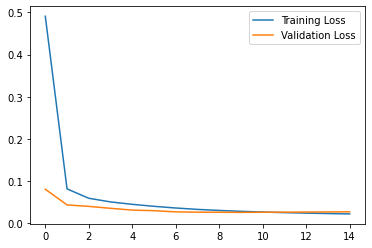

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## <font color='darkblue'>Detecting anomalies</font>
We will detect anomalies by determining how well our model can reconstruct the input data.
1. Find MAE loss on training samples.
2. Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the `threshold` for anomaly detection.
3. If the reconstruction loss for a sample is greater than this `threshold` value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

In [17]:
pdiff = np.abs(x_train_pred - x_train)
pdiff.shape

(3744, 288, 1)

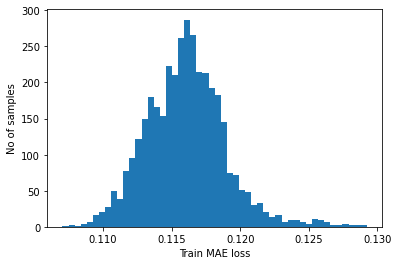

Reconstruction error threshold:  0.1292257430531349


In [14]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### <font color='darkgreen'>Compare recontruction</font>
Just for fun, **let's see how our model has recontructed the first sample. This is the 288 timesteps from day 1 of our training dataset.**

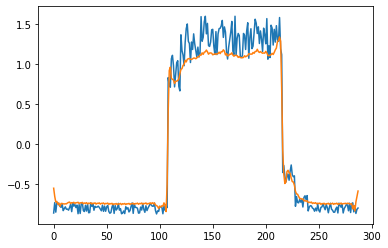

In [18]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### <font color='darkgreen'>Prepare test data</font>
Let's normalize our testing data and show how it looks:

In [22]:
df_daily_jumpsup.shape

(4032, 1)

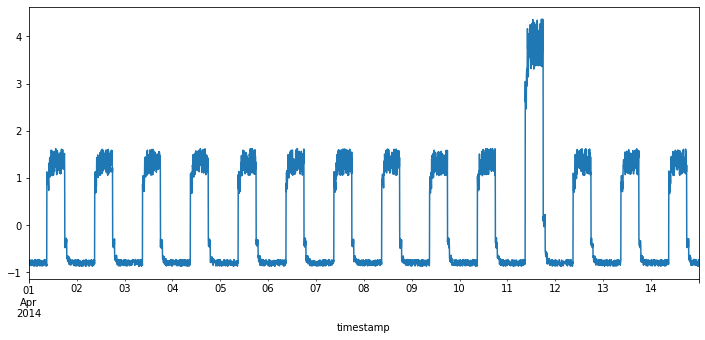

In [24]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

plt.rcParams["figure.figsize"]= (12, 5)
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

Test input shape:  (3744, 288, 1)


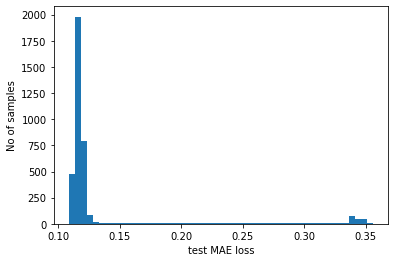

Number of anomaly samples:  407
Indices of anomaly samples:  (array([ 212,  789,  969, 1652, 1653, 1654, 1833, 1940, 1941, 2516, 2517,
       2697, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2

In [20]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

### <font color='darkgreen'>Plot anomalies</font>
We now know the samples of the data which are anomalies. With this, we will **find the corresponding timestamps from the original test data**. We will be using the following method to do that. Let's say `time_steps = 3` and we have 10 training values. Our `x_train` will look like this:
* 0, 1, 2
* 1, 2, 3
* 2, 3, 4
* 3, 4, 5
* 4, 5, 6
* 5, 6, 7
* 6, 7, 8
* 7, 8, 9

All except the initial and the final `time_steps-1` data values, will appear in `time_steps` number of samples. So, if we know that the samples `[(3, 4, 5), (4, 5, 6), (5, 6, 7)]` are anomalies, we can say that the data point 5 is an anomaly.

In [21]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

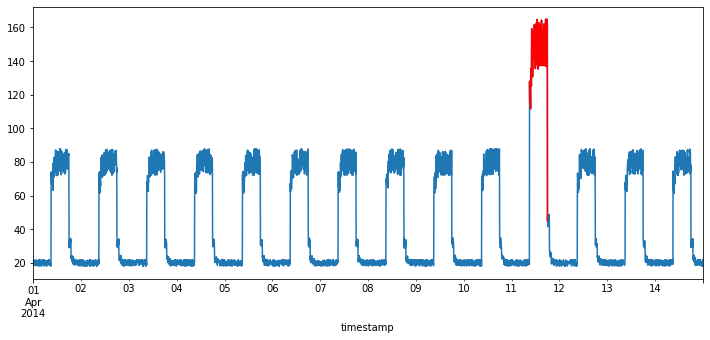

In [25]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
# Draw blue line
df_daily_jumpsup.plot(legend=False, ax=ax)

# Draw red line (anomaly points)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

Display all anomaly point found:

In [31]:
anomalous_data_indices = []
for data_idx in range(len(anomalies)):
    if anomalies[data_idx]:
        anomalous_data_indices.append(data_idx+TIME_STEPS-1)

df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
df_subset.head()

,value
timestamp,
2014-04-02 17:35:00,86.851892
2014-04-04 17:40:00,80.944143
2014-04-05 08:40:00,21.073104
2014-04-07 17:35:00,74.514577
2014-04-07 17:40:00,80.944074


In [45]:
df_subset.index.tolist()[:10]

[Timestamp('2014-04-02 17:35:00'),
 Timestamp('2014-04-04 17:40:00'),
 Timestamp('2014-04-05 08:40:00'),
 Timestamp('2014-04-07 17:35:00'),
 Timestamp('2014-04-07 17:40:00'),
 Timestamp('2014-04-07 17:45:00'),
 Timestamp('2014-04-08 08:40:00'),
 Timestamp('2014-04-08 17:35:00'),
 Timestamp('2014-04-08 17:40:00'),
 Timestamp('2014-04-10 17:35:00')]

In [44]:
df_subset['value'].tolist()[:10]

[86.8518921919,
 80.944143199,
 21.0731037912,
 74.5145765543,
 80.9440735412,
 82.61938031449999,
 19.215445856,
 86.66257341120001,
 78.2069311794,
 78.1045914874]

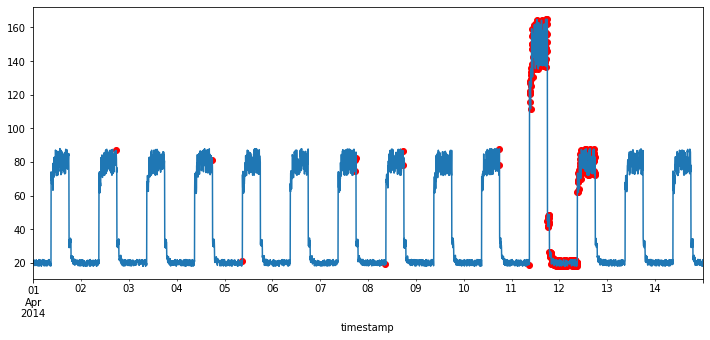

In [52]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
# df_subset.plot(legend=False, ax=ax, color="r", kind='scatter', x='x', y='value', style=".")
plt.scatter(df_subset.index, df_subset.value, color="r")
plt.show()